##### Master Degree in Computer Science and Data Science for Economics

# Introduction to encoding textual data

### Alfio Ferrara

## Introduction: what is the text for the machine

Example data are taken from [Climate Fever](https://huggingface.co/datasets/tdiggelm/climate_fever) and stored in MongoDb by this [script](./nlp/climate_data.py).

In [1]:
import pandas as pd
import numpy as np
import pymongo
from nltk.tokenize import sent_tokenize

In [9]:
db = pymongo.MongoClient()['climate']
collection = db['evidences']
records = list(collection.find({}, {'_id': 0, 'evidence': 1}))
docs = [doc['evidence'].strip('.').strip('"').lower() for doc in records]

In [10]:
print(f"Corpus size: {len(docs)}")
print(f"Corpus sample: {docs[0]}")

Corpus size: 7675
Corpus sample: recent research shows human activity driving earth towards global extinction event


### **What kind of tasks do we want to perform with textual information?**

- ...

In order to understand how even trivial tasks can be difficult for a machine, we need to figure out how the text appears to the machine eye:

In [11]:
from nlp.utils import messy_text

In [22]:
for text in docs[:6]:
    print(f"{messy_text(text)}\n")

htvtleyhtgtxhvrygribgyrdmxlyxveocoe yuhocolsytxheryeibxhugysniwxnytaeolveoilytctle

sianfhilsidvmynlgvudeyniumctsydosys,dniudnhiyhfyfsmhuvdnhiyhrylvi yegsunseyveydosnfysuhe edsleyuovipsxylhedynllstnvdsm ydosysianfhilsideyhryuhfvmyfssrexylhcidvniexyvitydosyvfudnu

dlclgnybphepdubadpcyeacmytppcybfybmpldyem clfifnlsuiyilhlbcxyugrysfairysuacpybmpyp,blgsblfgyfoytppyefeaiublfgc

dlclgnyniftuiybphepdubadpcvysuacpryt ybmpyndppgmfacpypoopsbvysfgbdltabpybfymutlbubyrpcbdasblfgvypgrugnpdlgny,udlfacycepslpcvycasmyucybmpyefiudytpud

tnucwlaebiemwruamlbwiewmhdtuhw ucgiemwontubn

bmpysaddpgbysfgcpgcacyfoybmpycslpgblolsysfhhaglb ylcybmubybmpyupdfcficyugryracbydpipucprylgbfybmpyaeepdyubhfcempdpysuacpcysffipdybphepdubadpcyt yedp'pgblgnybmpycagvcypgpdn yodfhydpusmlgnybmpyndfagr



## Vector Space Model
One way to transform a text into something that the machine can actually work with is to extract some features from the text and use them to transform each text into a vector of the same size of the features.

In [29]:
def type_token(text: str) -> float:
    tokens = text.split()
    if not tokens:
        return 0
    types = set(tokens)
    return len(types)

def features(text):
    return np.array([len(text), type_token(text)])

In [30]:
D = np.array([features(d) for d in docs])
D 

array([[ 82,  11],
       [178,  22],
       [110,  16],
       ...,
       [163,  26],
       [ 95,  13],
       [131,  23]])

In [31]:
import matplotlib.pyplot as plt

**Scale data**

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()
S = scaler.fit_transform(D)
row_norms = np.linalg.norm(S, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1
U = S / row_norms

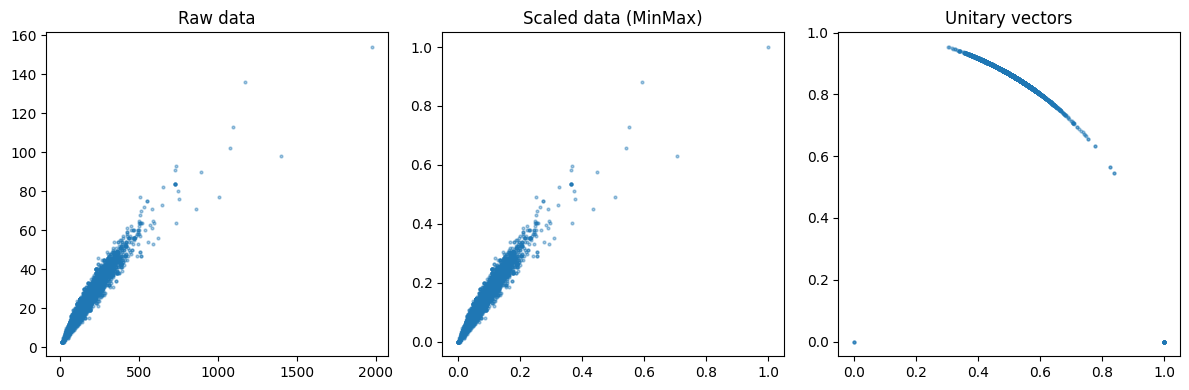

In [34]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].scatter(D[:,0], D[:,1], s=4, alpha=.4)
ax[0].set_title('Raw data')
ax[1].scatter(S[:,0], S[:,1], s=4, alpha=.4)
ax[1].set_title('Scaled data (MinMax)')
ax[2].scatter(U[:,0], U[:,1], s=4, alpha=.4)
ax[2].set_title('Unitary vectors')
plt.tight_layout()
plt.show()

## Words as features

### Regural expression tokenizers

In [35]:
from nltk.tokenize import word_tokenize

In [36]:
for doc in docs[:10]:
    print(word_tokenize(doc, language='english'))

['recent', 'research', 'shows', 'human', 'activity', 'driving', 'earth', 'towards', 'global', 'extinction', 'event']
['environmental', 'impacts', 'include', 'the', 'extinction', 'or', 'relocation', 'of', 'many', 'species', 'as', 'their', 'ecosystems', 'change', ',', 'most', 'immediately', 'the', 'environments', 'of', 'coral', 'reefs', ',', 'mountains', ',', 'and', 'the', 'arctic']
['rising', 'temperatures', 'push', 'bees', 'to', 'their', 'physiological', 'limits', ',', 'and', 'could', 'cause', 'the', 'extinction', 'of', 'bee', 'populations']
['rising', 'global', 'temperatures', ',', 'caused', 'by', 'the', 'greenhouse', 'effect', ',', 'contribute', 'to', 'habitat', 'destruction', ',', 'endangering', 'various', 'species', ',', 'such', 'as', 'the', 'polar', 'bear']
['bear', 'hunting', 'caught', 'in', 'global', 'warming', 'debate']
['the', 'current', 'consensus', 'of', 'the', 'scientific', 'community', 'is', 'that', 'the', 'aerosols', 'and', 'dust', 'released', 'into', 'the', 'upper', 'atm

#### Normalization

In [37]:
from string import punctuation

In [38]:
def norm_tokenizer(doc):
    return [x.lower() for x in word_tokenize(doc) if x not in punctuation]

In [39]:
norm_tokenizer(docs[0])[:6]

['recent', 'research', 'shows', 'human', 'activity', 'driving']

### Indexing

In [40]:
from collections import defaultdict, Counter

In [41]:
corpus = []
for doc in docs:
    tokens = norm_tokenizer(doc)
    corpus.append(dict(Counter(tokens).most_common()))
C = pd.DataFrame(corpus)
C 

,recent,research,shows,human,activity,driving,earth,towards,global,extinction,...,answers,wilson,80-,hydrostatic,translates,erupt,mafic,pāhoehoe,make-up,fluidity
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
C.fillna(0).head(4)

,recent,research,shows,human,activity,driving,earth,towards,global,extinction,...,answers,wilson,80-,hydrostatic,translates,erupt,mafic,pāhoehoe,make-up,fluidity
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
dict(Counter(norm_tokenizer(docs[20])).most_common())

{'co': 2,
 '2': 2,
 'is': 2,
 'the': 2,
 'in': 2,
 'to': 2,
 'while': 1,
 'absorption': 1,
 'and': 1,
 'release': 1,
 'always': 1,
 'happening': 1,
 'as': 1,
 'a': 1,
 'result': 1,
 'of': 1,
 'natural': 1,
 'processes': 1,
 'recent': 1,
 'rise': 1,
 'levels': 1,
 'atmosphere': 1,
 'known': 1,
 'be': 1,
 'mainly': 1,
 'due': 1,
 'human': 1,
 'anthropogenic': 1,
 'activity': 1}

### Linguistic-based tokenizers

In [46]:
import spacy
from spacy.displacy import render

In [47]:
nlp = spacy.load('en_core_web_lg')

In [48]:
tokens = []
for token in nlp(docs[2]):
    tokens.append({'text': token.text, 'lemma': token.lemma_, 'pos': token.pos_, 
                   'tag': token.tag_, 'dep': token.dep_, 'shape': token.shape_, 
                   'alpha': token.is_alpha, 'stopword': token.is_stop})
T = pd.DataFrame(tokens)

In [49]:
T.head(20)

,text,lemma,pos,tag,dep,shape,alpha,stopword
0,rising,rise,VERB,VBG,amod,xxxx,True,False
1,temperatures,temperature,NOUN,NNS,nsubj,xxxx,True,False
2,push,push,VERB,VBP,ROOT,xxxx,True,False
3,bees,bee,NOUN,NNS,dobj,xxxx,True,False
4,to,to,ADP,IN,prep,xx,True,True
5,their,their,PRON,PRP$,poss,xxxx,True,True
6,physiological,physiological,ADJ,JJ,amod,xxxx,True,False
7,limits,limit,NOUN,NNS,pobj,xxxx,True,False
8,",",",",PUNCT,",",punct,",",False,False
9,and,and,CCONJ,CC,cc,xxx,True,True


In [50]:
sentence = docs[0]
render(nlp(sentence))

In [51]:
for n in nlp(sentence).noun_chunks:
    print(n)

recent research
human activity
earth
global extinction event


In [52]:
def spacy_tokenizer(text, lowercase=True, lemma=True, keep_pos=None):
    def selector(token, lemma=lemma, keep_pos=keep_pos):
        if keep_pos is None or token.pos_ in keep_pos:
            if lemma:
                return token.lemma_ 
            else:
                return token.text 
    tokens = []
    for token in nlp(text):
        s = selector(token)
        if s is not None:
            if lowercase:
                tokens.append(s.lower())
            else:
                tokens.append(s)
    return tokens

In [53]:
for doc in docs[:10]:
    print(spacy_tokenizer(doc, lowercase=True, lemma=True, keep_pos=['PROPN', 'VERB', 'ADJ', 'ADV', 'AUX']))

['recent', 'show', 'human', 'drive', 'global']
['environmental', 'include', 'many', 'change', 'most', 'immediately', 'coral', 'arctic']
['rise', 'push', 'physiological', 'could', 'cause']
['rise', 'global', 'cause', 'contribute', 'endanger', 'various', 'such', 'polar']
['catch', 'global']
['current', 'scientific', 'be', 'release', 'upper', 'cause', 'cool', 'prevent', 'reach']
['little', 'cause', 'europe']
['persistently', 'cold', 'wet', 'cause', 'great', 'be', 'primarily', 'responsible', 'great', 'strongly', 'contribute', 'weaken', 'lead', 'black']
['meteorological', 'freeze', 'northerly', 'prone', 'be', 'highly', 'variable', 'depend', 'marine']
['many', 'be', 'associate', 'freezing']


### Size of the vocabulary with different types of tokenizers

In [54]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [55]:
nltk_vocabulary = defaultdict(lambda: 0)
spacy_vocabulary = defaultdict(lambda: 0)
step = 10

def counter(docs: list, tokenizer: callable, vocabulary: dict, step: int = 10):
    run = list(enumerate(docs))
    stats = []
    for i, doc in tqdm(run):
        if i % step == 0:
            stats.append(len(vocabulary))
        for token in tokenizer(doc):
            vocabulary[token] += 1
    return stats 

nltk_stats = counter(docs, word_tokenize, nltk_vocabulary, step=step)
spacy_stats = counter(docs, spacy_tokenizer, spacy_vocabulary, step=step)


  0%|          | 0/7675 [00:00<?, ?it/s]

  0%|          | 0/7675 [00:00<?, ?it/s]

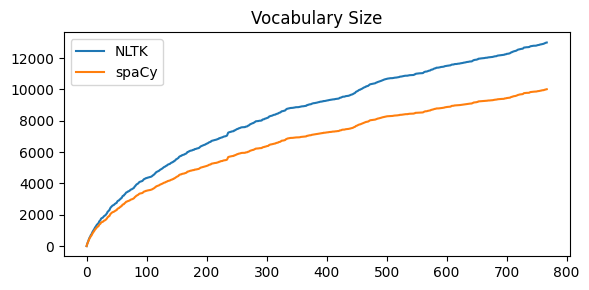

In [56]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_title('Vocabulary Size')
ax.plot(nltk_stats, label='NLTK')
ax.plot(spacy_stats, label='spaCy')
ax.legend()
plt.tight_layout()
plt.show()

### Learning tokenization

For an introduction to methods based on WordPiece see [WordPiece Example](./L0.1-wordpiece-example.ipynb)

WordPiece is a subword-based tokenization algorithm commonly used in transformer-based models like BERT. It improves efficiency by balancing vocabulary size and representation power. The goal of training is to construct an optimal vocabulary from raw text data, balancing vocabulary size with subword efficiency.

#### Step 1: Start with a Base Vocabulary
The initial vocabulary contains all single Unicode characters (A-Z, a-z, 0-9, punctuation) plus special tokens like `[UNK]`.

#### Step 2: Compute Frequency of Character Sequences
We scan the training corpus and count the occurrence of every pairs of tokens (initially each char is seen as a token), by marking with a special characted the tokens that are not the initial ones.

In [57]:
import nltk

In [58]:
corpus = ["play", "playing", "played", "plays", "playful"]
vocabulary = defaultdict(lambda: 0)
c_prefix = "##"

def update_vocabulary(corpus, vocabulary, c_prefix):
    for text in corpus:
        for i, (a, b) in enumerate(nltk.ngrams(text, n=2)):
            if i == 0:
                vocabulary[(a, f"{c_prefix}{b}")] += 1
            else:
                vocabulary[(f"{c_prefix}{a}", f"{c_prefix}{b}")] += 1

update_vocabulary(corpus=corpus, vocabulary=vocabulary, c_prefix=c_prefix)

pd.Series(vocabulary).sort_values(ascending=False)

p    ##l    5
##l  ##a    5
##a  ##y    5
##y  ##i    1
##i  ##n    1
##n  ##g    1
##y  ##e    1
##e  ##d    1
##y  ##s    1
     ##f    1
##f  ##u    1
##u  ##l    1
dtype: int64

#### Step 3: Merge the Most Frequent Pair and Update the Corpus
We merge the two most frequent pair and update the vocabulary and the corpus by substituting this sequence with a single token

In [59]:
pair = list(pd.Series(vocabulary).sort_values(ascending=False).head(1).keys())[0]
new_token = f"{pair[0].replace(c_prefix, '')}{pair[1].replace(c_prefix, '')}"

vocabulary[new_token] = vocabulary[pair]

def wordpiece_split(word, vocabulary):
    tokens = []
    i = 0
    while i < len(word):
        matched = None
        for j in range(len(word), i, -1):
            subword = word[i:j]
            if subword in vocabulary:
                matched = subword
                break
        if matched is None:
            matched = word[i]
        tokens.append(matched)
        i += len(matched)
    return tokens

print(wordpiece_split("play", vocabulary=vocabulary))
print(wordpiece_split("hello", vocabulary=vocabulary))
#print(wordpiece_split("pluto", vocabulary=vocabulary))


new_corpus = []
for text in corpus:
    tokens = wordpiece_split(text, vocabulary=vocabulary)
    new_corpus.append(tokens)

corpus = new_corpus

['pl', 'a', 'y']
['h', 'e', 'l', 'l', 'o']


In [60]:
corpus

[['pl', 'a', 'y'],
 ['pl', 'a', 'y', 'i', 'n', 'g'],
 ['pl', 'a', 'y', 'e', 'd'],
 ['pl', 'a', 'y', 's'],
 ['pl', 'a', 'y', 'f', 'u', 'l']]

#### Step 4: Repeat until we reach the maximum size of vocabulary
From there on, all the non maching string portions will be left alone


In [61]:
update_vocabulary(corpus=corpus, vocabulary=vocabulary, c_prefix=c_prefix)

In [62]:
pd.Series(vocabulary).sort_values(ascending=False)

(##a, ##y)    10
(p, ##l)       5
(##l, ##a)     5
pl             5
(pl, ##a)      5
(##y, ##i)     2
(##i, ##n)     2
(##n, ##g)     2
(##y, ##e)     2
(##e, ##d)     2
(##y, ##s)     2
(##y, ##f)     2
(##f, ##u)     2
(##u, ##l)     2
dtype: int64

In [63]:
pair = list(pd.Series(vocabulary).sort_values(ascending=False).head(1).keys())[0]
new_token = f"{pair[0].replace(c_prefix, '')}{pair[1].replace(c_prefix, '')}"

print(new_token)

vocabulary[new_token] = vocabulary[pair]

new_corpus = []
for text in corpus:
    tokens = wordpiece_split("".join(text), vocabulary=vocabulary)
    new_corpus.append(tokens)

corpus = new_corpus

print(corpus)

ay
[['pl', 'ay'], ['pl', 'ay', 'i', 'n', 'g'], ['pl', 'ay', 'e', 'd'], ['pl', 'ay', 's'], ['pl', 'ay', 'f', 'u', 'l']]


**Note**: this naive implementation does now work completely; for a usable example you can check here [WordPieace](L0.1-wordpiece-example.ipynb)